<h2>Project of regression problem</h2>

Problem description:

Goal: Find the most optimal representation of insurance charges, represented in a column "charges".

Dataset: This dataset contains medical insurance cost information for 1338 individuals. It includes demographic and health-related variables such as age, sex, BMI, number of children, smoking status, and residential region in the US. The target variable is charges, which represents the medical insurance cost billed to the individual.

Models used: 
- Random Forest, 
- Extreme Gradient Boost,
- Deep Neural Network (Linear, BatchNorm, RELu, Dropout)

Metrics:
- Mean Squared error for comparison of models
- Mean Absolute Error for measuring charge inaccuracy
- Mean Absolute Percentage Error for measuring percentage charge inaccuracy
- R2 for measuring model variance

In [1]:
import pandas as pd, matplotlib.pyplot as plt
import seaborn as sb
import warnings, xgboost
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from scipy import stats

<h2>Data preparation</h2>
In this stage we conduct data preparation to ensure the missing data, wrong data types and basic feature engineering are in place.

In [2]:
regression_dataset = pd.read_csv('./data/medical insurance/insurance.csv')

In [3]:
regression_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
regression_dataset.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Visualizing of data to get as much information as possible

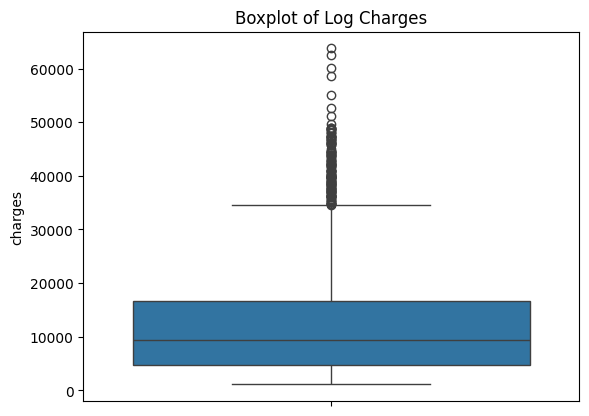

In [5]:
sb.boxplot(regression_dataset['charges'])
plt.title('Boxplot of Log Charges')
plt.show()

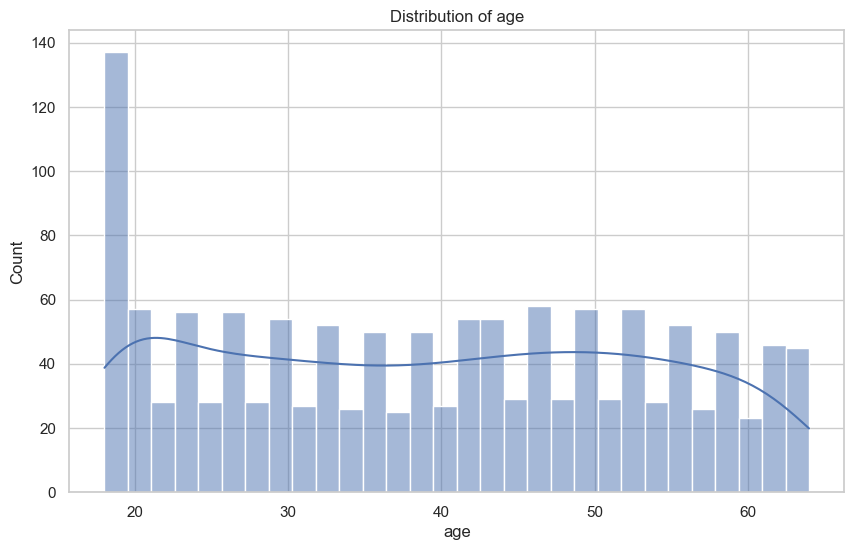

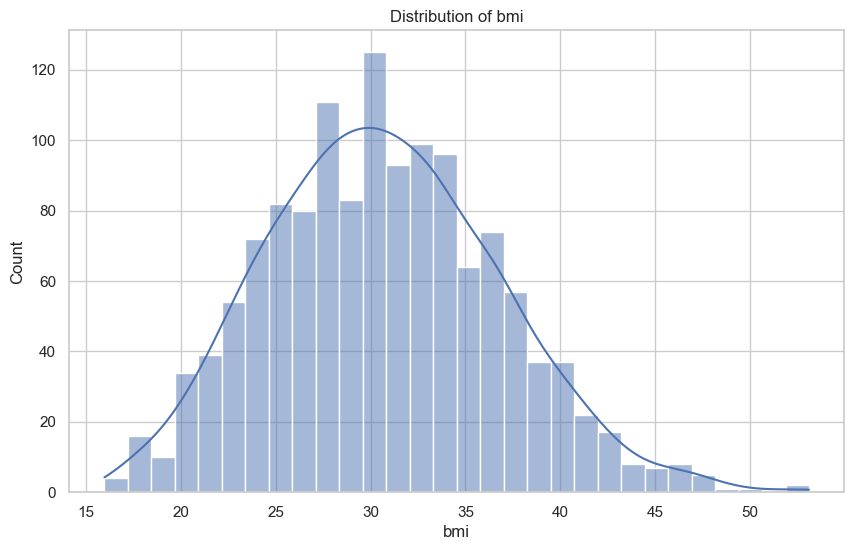

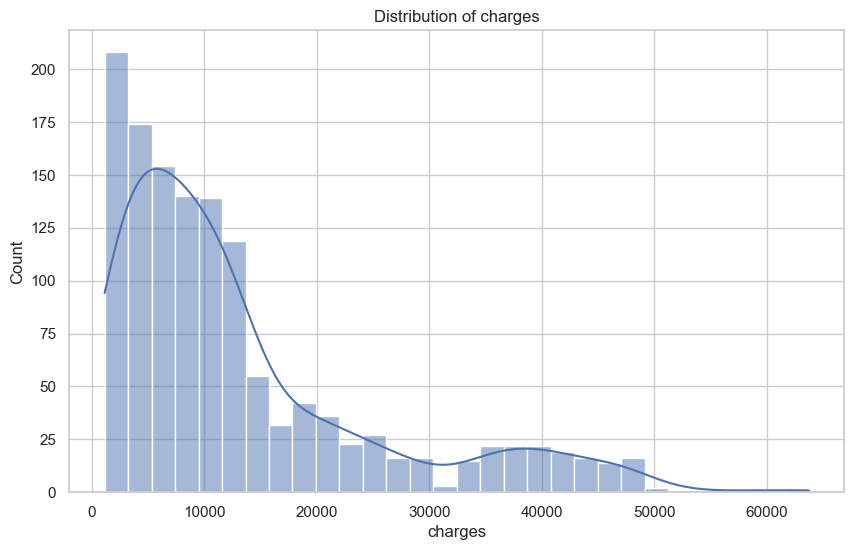

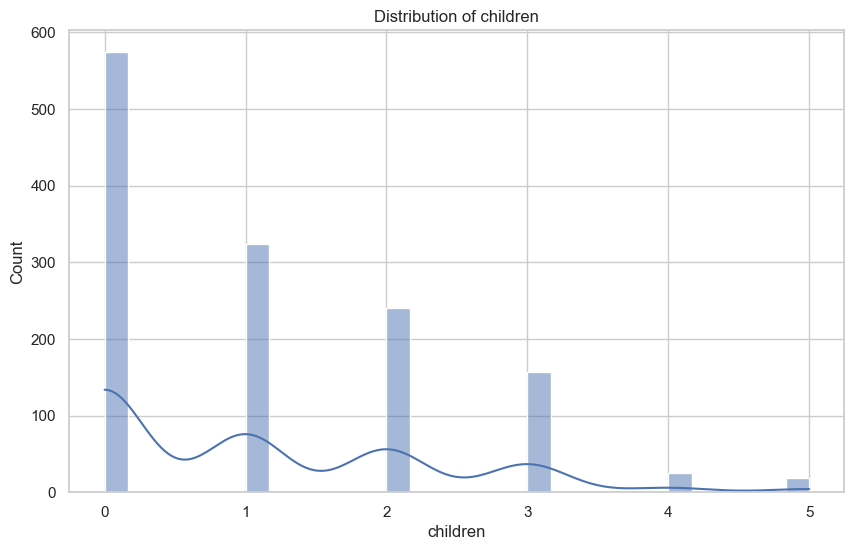

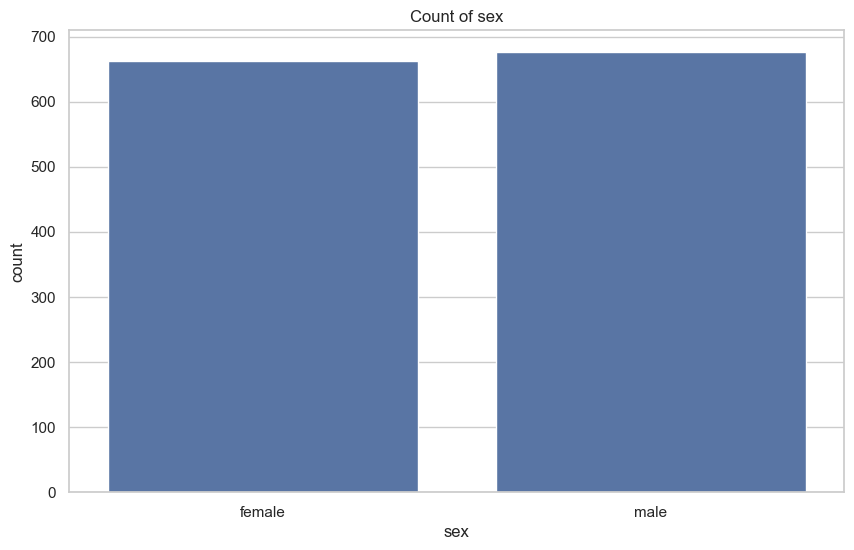

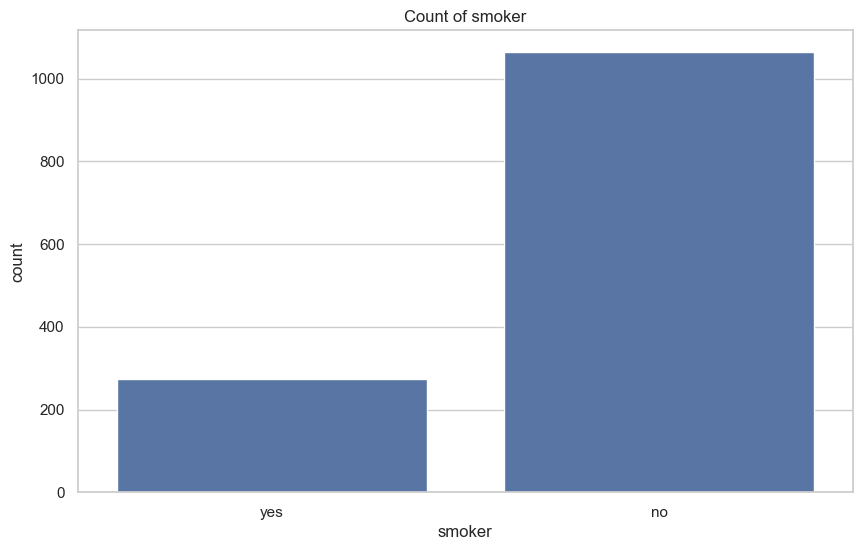

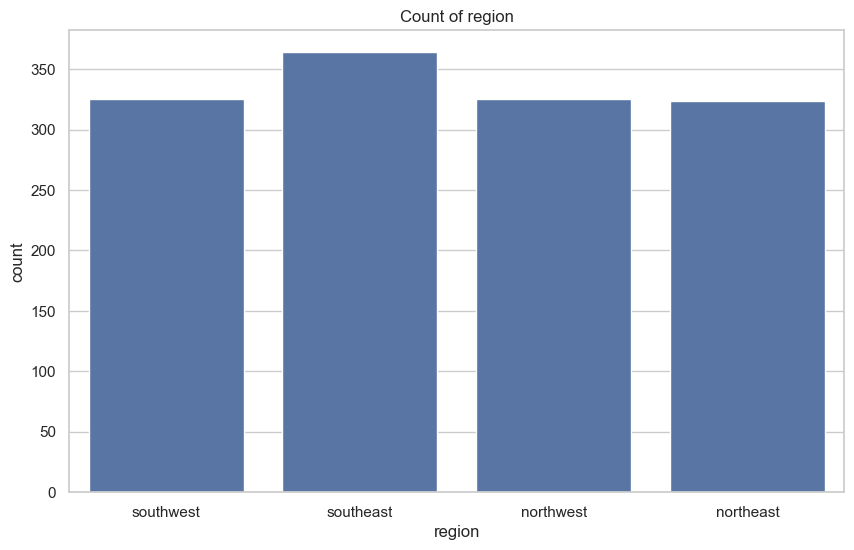

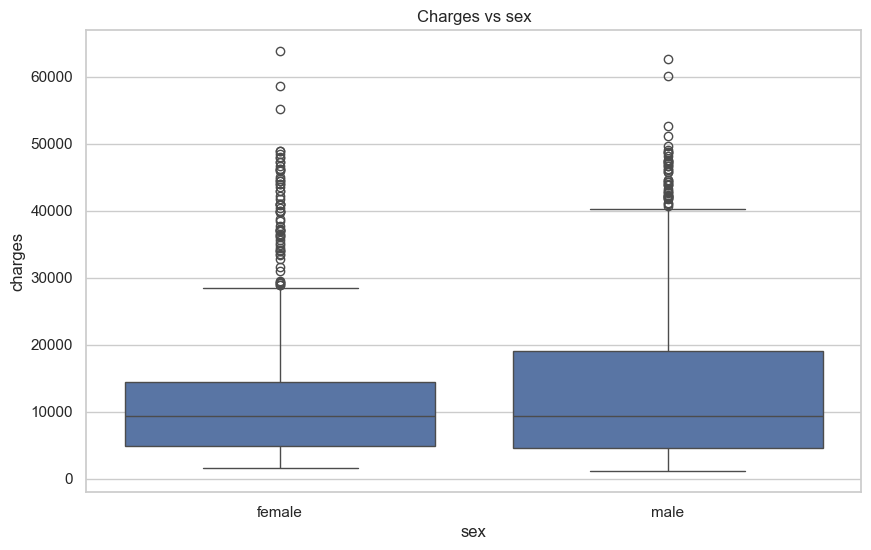

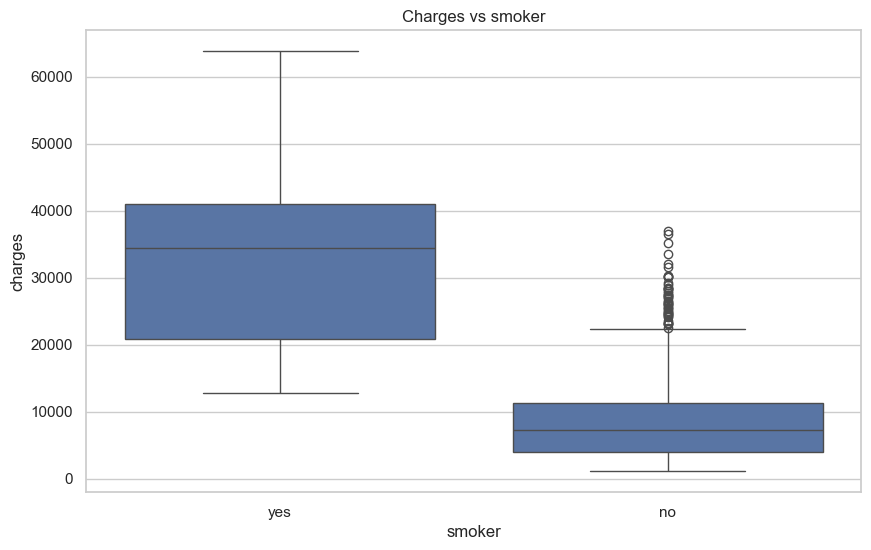

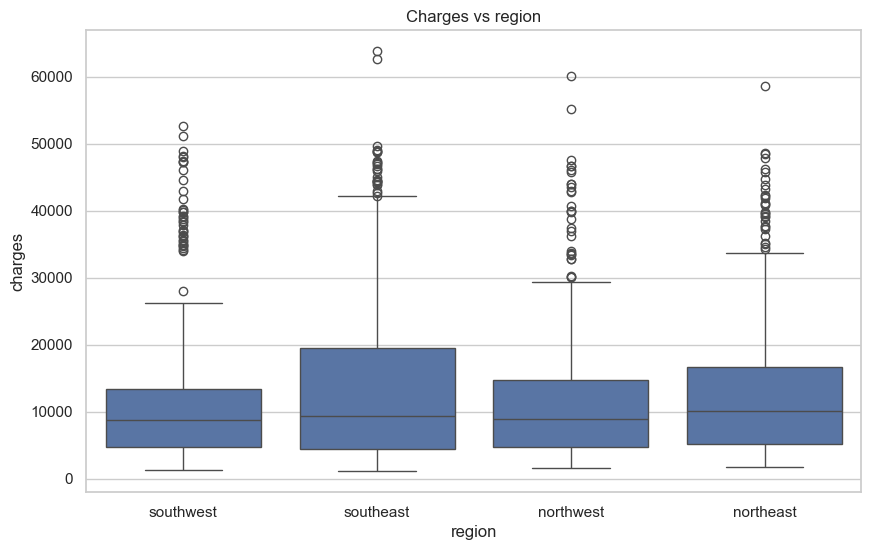

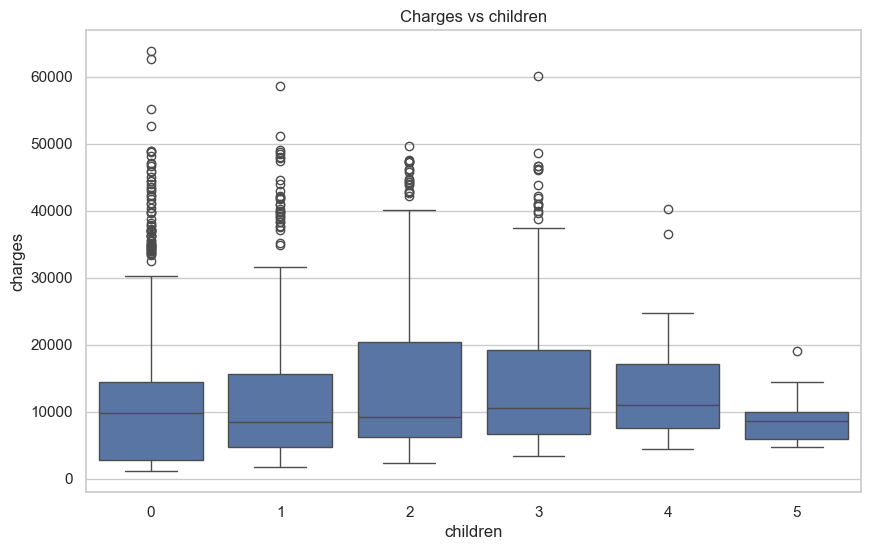

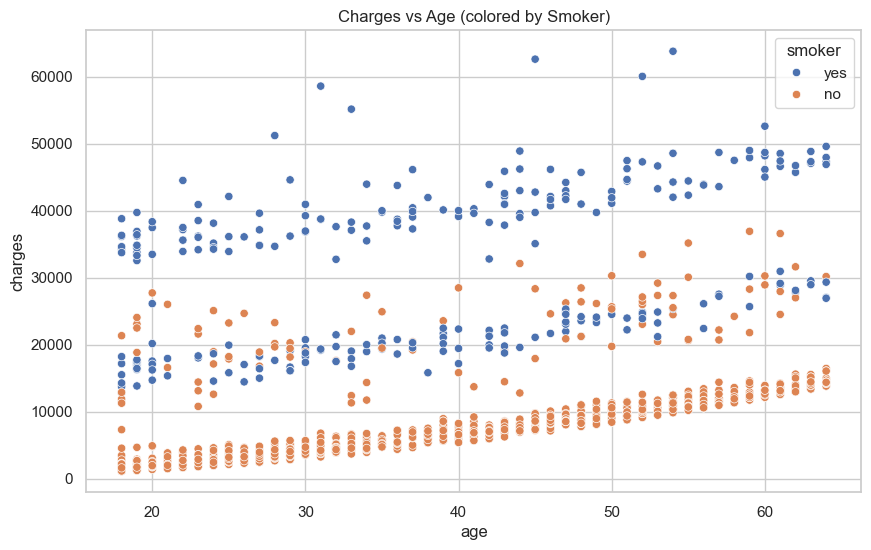

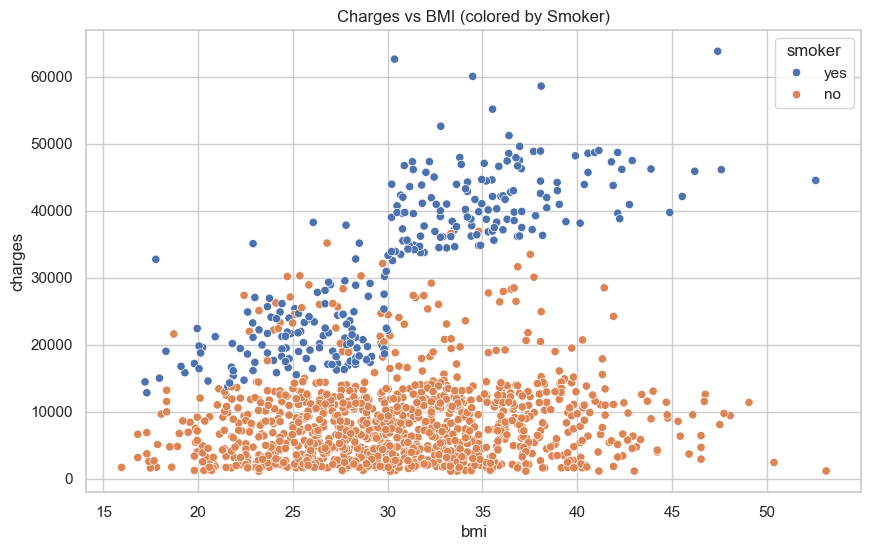

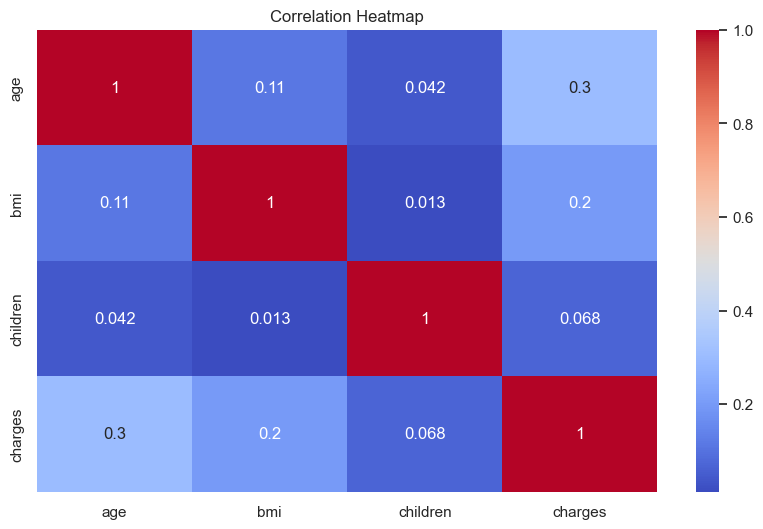

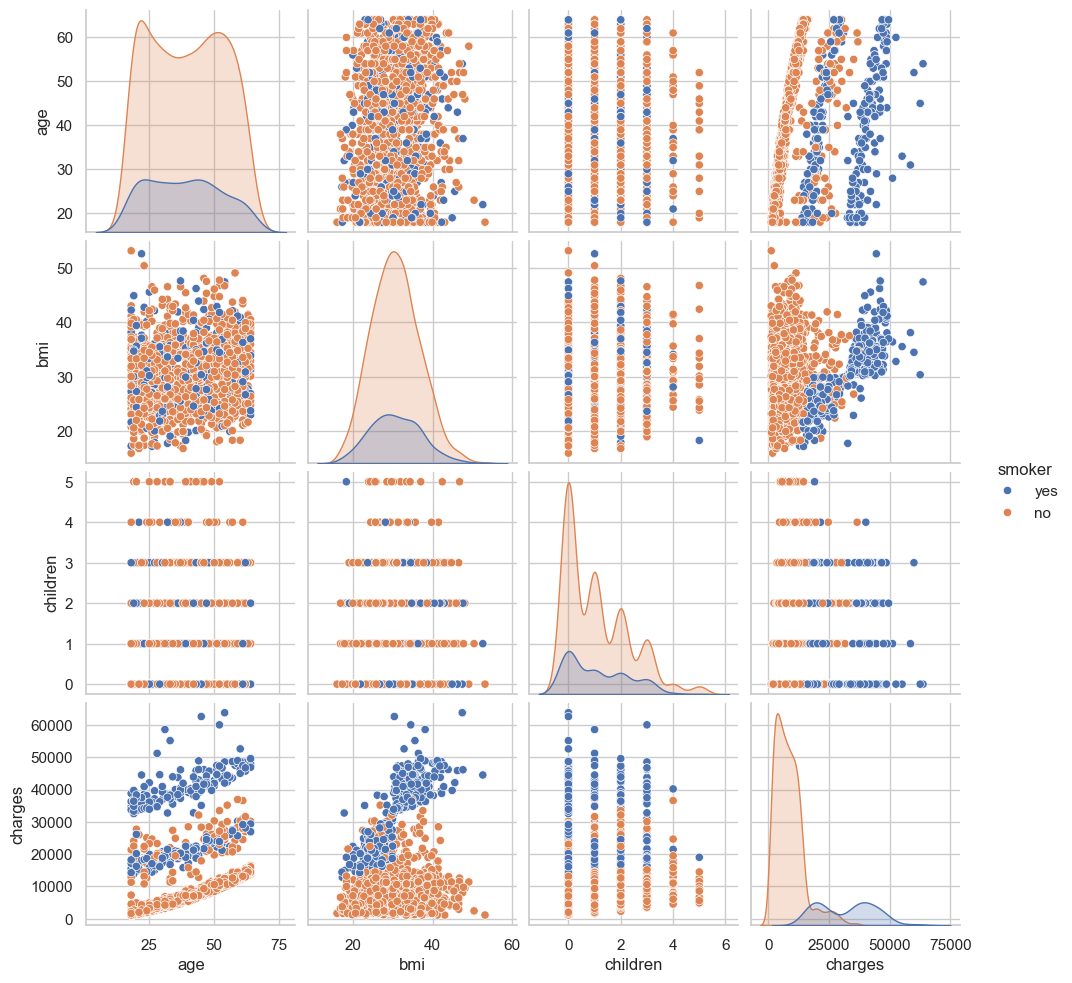

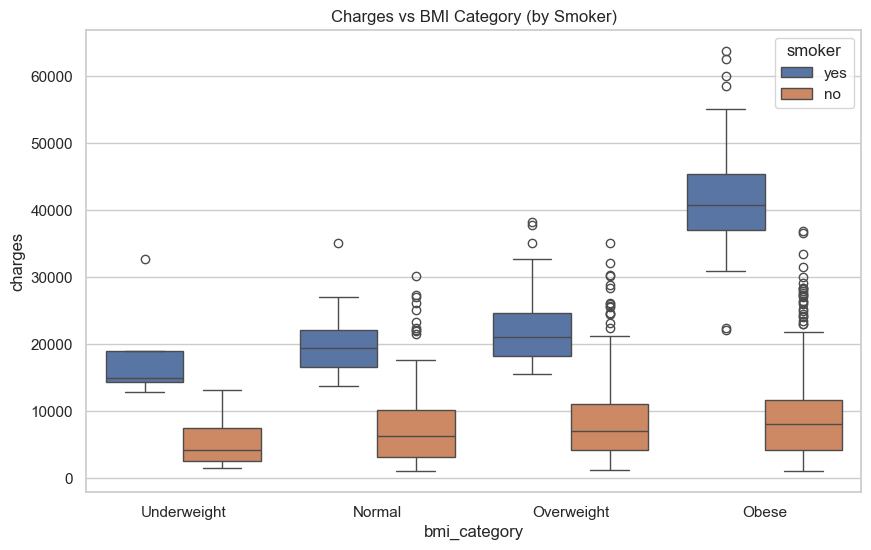

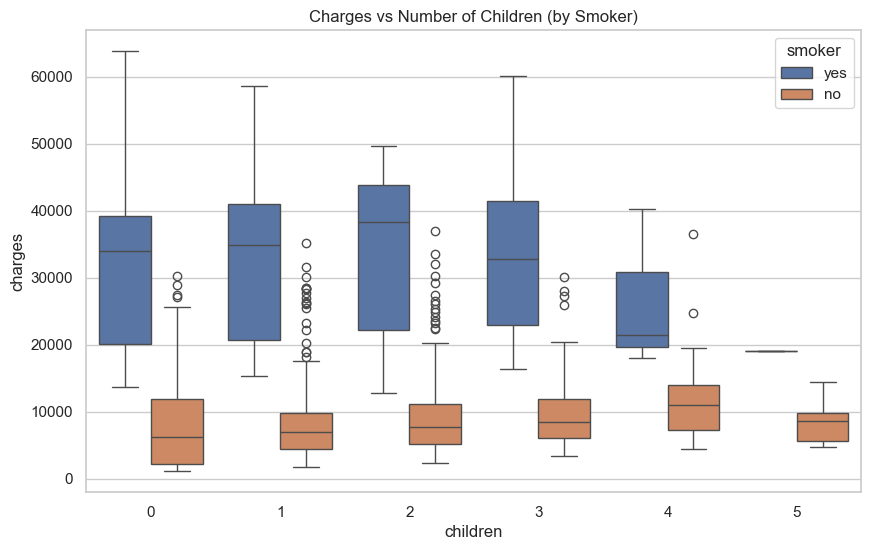

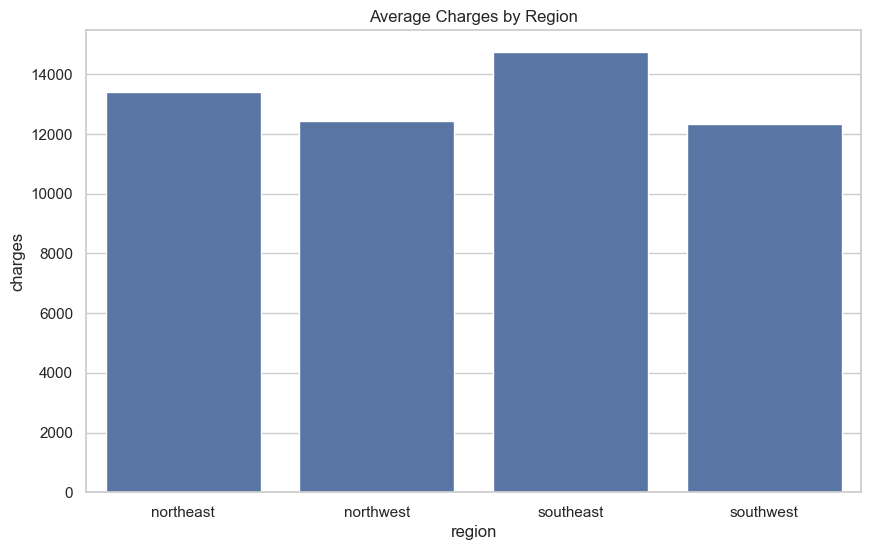

In [6]:
regression_dataset2 = pd.read_csv('./data/medical insurance/insurance.csv')

sb.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

numeric_cols = ['age', 'bmi', 'charges', 'children']
for col in numeric_cols:
    plt.figure()
    sb.histplot(regression_dataset2[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    plt.figure()
    sb.countplot(x=col, data=regression_dataset2)
    plt.title(f'Count of {col}')
    plt.show()

for col in ['sex', 'smoker', 'region', 'children']:
    plt.figure()
    sb.boxplot(x=col, y='charges', data=regression_dataset2)
    plt.title(f'Charges vs {col}')
    plt.show()

plt.figure()
sb.scatterplot(x='age', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs Age (colored by Smoker)')
plt.show()

plt.figure()
sb.scatterplot(x='bmi', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs BMI (colored by Smoker)')
plt.show()

plt.figure()
sb.heatmap(regression_dataset2[['age','bmi','children','charges']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sb.pairplot(regression_dataset2[['age','bmi','children','charges','smoker']], hue='smoker')
plt.show()


bins = [0, 18.5, 24.9, 29.9, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
regression_dataset2['bmi_category'] = pd.cut(regression_dataset2['bmi'], bins=bins, labels=labels)

plt.figure()
sb.boxplot(x='bmi_category', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs BMI Category (by Smoker)')
plt.show()

plt.figure()
sb.boxplot(x='children', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs Number of Children (by Smoker)')
plt.show()

region_avg = regression_dataset2.groupby('region')['charges'].mean().reset_index()
plt.figure()
sb.barplot(x='region', y='charges', data=region_avg)
plt.title('Average Charges by Region')
plt.show()


In [7]:
regression_dataset['sex'] = regression_dataset['sex'].map({'male': 0,'female': 1})
regression_dataset['smoker'] = regression_dataset['smoker'].map({'no': 0,'yes': 1})
regression_dataset['region'] = regression_dataset['region'].map({'southwest': 0,'northwest': 1,'northeast': 2,'southeast': 3})
print(regression_dataset['region'].unique())
print(regression_dataset.isna().sum())

[0 3 1 2]
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [8]:
y = regression_dataset['charges']
X = regression_dataset.drop('charges', axis=1)

<h3>Testing log charges for skewing</h3>

In [9]:
import numpy as np

In [10]:
y_log = np.log1p(y)

<h3>Extracting Polynomial Features</h3>

In [11]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
numeric_poly = ['age', 'bmi']
poly_vals = poly.fit_transform(X[numeric_poly])

poly_df = pd.DataFrame(
    poly_vals, 
    columns=poly.get_feature_names_out(numeric_poly),
    index=X.index
)
poly_df = poly_df.drop(['age', 'bmi', 'age bmi'], axis=1)

#add latter or dont xD
X = pd.concat([X, poly_df], axis=1)


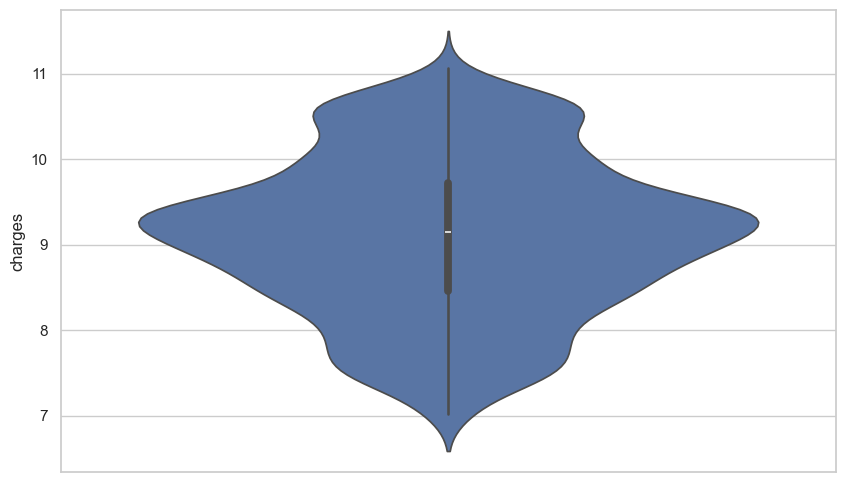

In [12]:
ax3 = sb.violinplot(data=y_log)

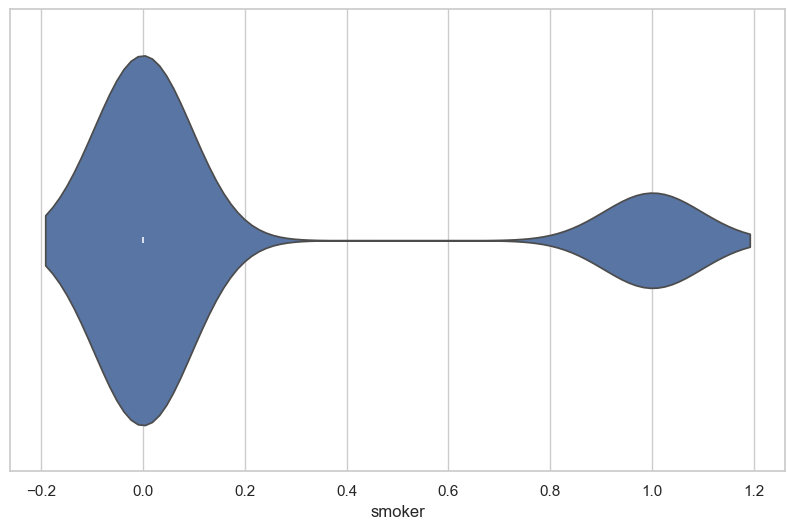

In [13]:
ax1 = sb.violinplot(x='smoker', data=regression_dataset)

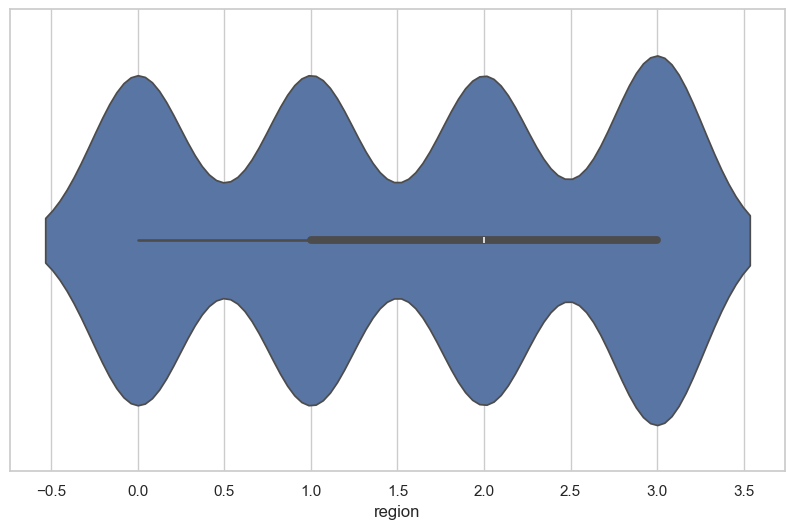

In [14]:
ax1 = sb.violinplot(x='region', data=regression_dataset)

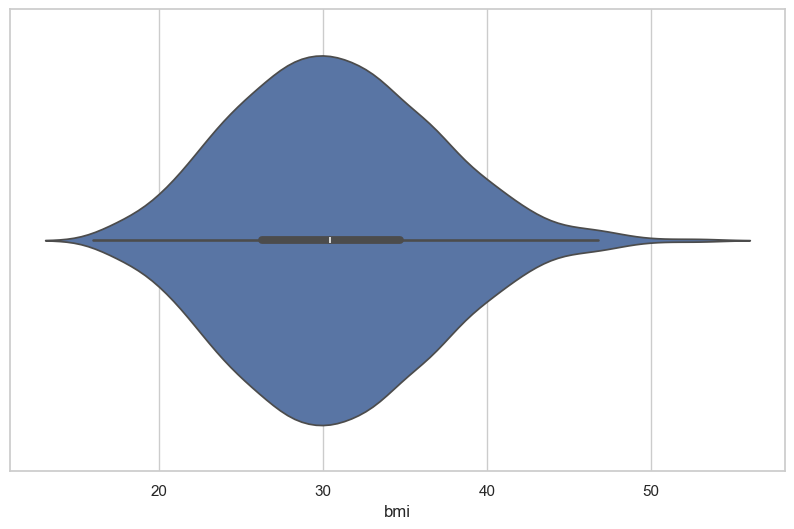

In [15]:
ax1 = sb.violinplot(x='bmi', data=regression_dataset)

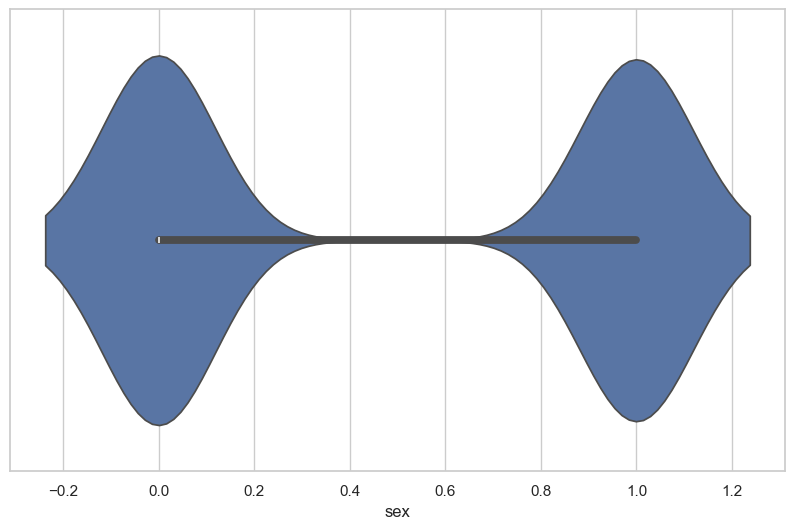

In [16]:
ax1 = sb.violinplot(x='sex', data=regression_dataset)

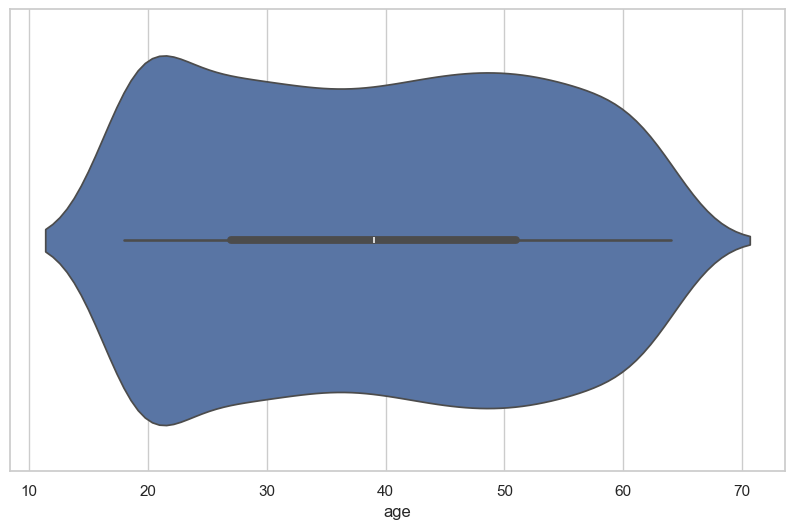

In [17]:
ax1 = sb.violinplot(x='age', data=regression_dataset)

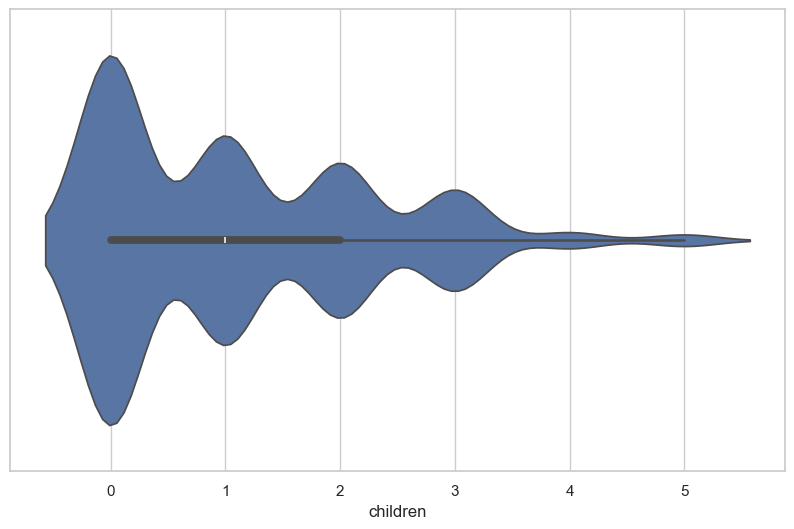

In [18]:
ax2 = sb.violinplot(x='children', data=regression_dataset)

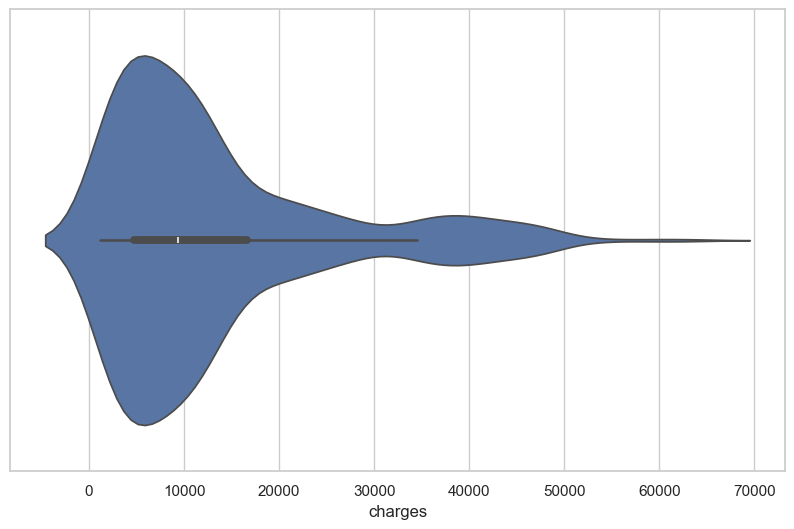

In [19]:
ax3 = sb.violinplot(x='charges', data=regression_dataset)

<h3>Correlation Analysis</h3>
PRedictors are weakly correlated between each other but there is significant impact of age and smoking on the charges size.

In [20]:
!pip install Jinja2


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
#different corr
corr = regression_dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,bmi,children,smoker,region,charges
age,1.000000,0.020856,0.109272,0.042469,-0.025019,-0.012027,0.299008
sex,0.020856,1.000000,-0.046371,-0.017163,-0.076185,-0.014144,-0.057292
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,0.162590,0.198341
children,0.042469,-0.017163,0.012759,1.000000,0.007673,-0.035115,0.067998
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,0.069008,0.787251
region,-0.012027,-0.014144,0.162590,-0.035115,0.069008,1.000000,0.077042
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,0.077042,1.000000


In [22]:
corr2 = regression_dataset.corr(method='kendall')
corr2.style.background_gradient(cmap='coolwarm')

,age,sex,bmi,children,smoker,region,charges
age,1.000000,0.017186,0.073273,0.043253,-0.020821,-0.012925,0.475302
sex,0.017186,1.000000,-0.036630,-0.014317,-0.076185,-0.013036,-0.007751
bmi,0.073273,-0.036630,1.000000,0.011562,0.001801,0.107854,0.082524
children,0.043253,-0.014317,0.011562,1.000000,0.015231,-0.024557,0.103107
smoker,-0.020821,-0.076185,0.001801,0.015231,1.000000,0.063291,0.541916
region,-0.012925,-0.013036,0.107854,-0.024557,0.063291,1.000000,0.035778
charges,0.475302,-0.007751,0.082524,0.103107,0.541916,0.035778,1.000000


In [23]:
corr3 = regression_dataset.corr(method='spearman')
corr3.style.background_gradient(cmap='coolwarm')

,age,sex,bmi,children,smoker,region,charges
age,1.000000,0.020809,0.107736,0.056992,-0.025210,-0.017172,0.534392
sex,0.020809,1.000000,-0.044802,-0.015589,-0.076185,-0.014277,-0.009490
bmi,0.107736,-0.044802,1.000000,0.015607,0.002203,0.148024,0.119396
children,0.056992,-0.015589,0.015607,1.000000,0.016583,-0.029366,0.133339
smoker,-0.025210,-0.076185,0.002203,0.016583,1.000000,0.069320,0.663460
region,-0.017172,-0.014277,0.148024,-0.029366,0.069320,1.000000,0.046677
charges,0.534392,-0.009490,0.119396,0.133339,0.663460,0.046677,1.000000


<h2>Feature Engineering</h2>

In [24]:
regression_dataset.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,0,30.97,3,0,1,10600.5483
1334,18,1,31.92,0,0,2,2205.9808
1335,18,1,36.85,0,0,3,1629.8335
1336,21,1,25.80,0,0,0,2007.9450
1337,61,1,29.07,0,1,1,29141.3603


In [25]:
X.tail()

,age,sex,bmi,children,smoker,region,age^2,bmi^2
1333,50,0,30.97,3,0,1,2500.0,959.1409
1334,18,1,31.92,0,0,2,324.0,1018.8864
1335,18,1,36.85,0,0,3,324.0,1357.9225
1336,21,1,25.80,0,0,0,441.0,665.6400
1337,61,1,29.07,0,1,1,3721.0,845.0649


In [26]:
age_bins = [0, 25, 35, 45, 55, 65, 100]  # 0-25, 26-35, etc.
age_labels = ["0_25", "26_35", "36_45", "46_55", "56_65", "65"]
X["age_group"] = pd.cut(X["age"], bins=age_bins, labels=age_labels, right=True)

bmi_bins = [0, 18.5, 24.9, 29.9, 100]  # underweight, normal, overweight, obese
bmi_labels = ["underweight", "normal", "overweight", "obese"]
X["bmi_category"] = pd.cut(X["bmi"], bins=bmi_bins, labels=bmi_labels, right=True)


In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [28]:
X.tail()

,age,sex,bmi,children,smoker,region,age^2,bmi^2,age_group,bmi_category
1333,50,0,30.97,3,0,1,2500.0,959.1409,46_55,obese
1334,18,1,31.92,0,0,2,324.0,1018.8864,0_25,obese
1335,18,1,36.85,0,0,3,324.0,1357.9225,0_25,obese
1336,21,1,25.80,0,0,0,441.0,665.6400,0_25,overweight
1337,61,1,29.07,0,1,1,3721.0,845.0649,56_65,overweight


In [29]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on numeric features of X
X_numeric_scaled = scaler.fit_transform(X[numeric_features])

# Convert back to DataFrame if you want
X_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numeric_features, index=X.index)

# Replace original numeric columns with scaled values
X[numeric_features] = X_scaled_df

print(X.tail())

           age  sex       bmi  children  smoker  region   age^2      bmi^2  \
1333  0.768473    0  0.050297  1.580926       0       1  2500.0   959.1409   
1334 -1.509965    1  0.206139 -0.908614       0       2   324.0  1018.8864   
1335 -1.509965    1  1.014878 -0.908614       0       3   324.0  1357.9225   
1336 -1.296362    1 -0.797813 -0.908614       0       0   441.0   665.6400   
1337  1.551686    1 -0.261388 -0.908614       1       1  3721.0   845.0649   

     age_group bmi_category  
1333     46_55        obese  
1334      0_25        obese  
1335      0_25        obese  
1336      0_25   overweight  
1337     56_65   overweight  


<h3>Even though the smoker column is imbalanced, there is no stronge noise or overfitting risk</h3>

In [30]:
from sklearn.feature_selection import mutual_info_regression

imbalance_ratio = X['smoker'].value_counts(normalize=True)
mi = mutual_info_regression(X[['smoker']], y)

print(f"Imbalance ratio: {imbalance_ratio.to_dict()}")
print(f"Mutual information with target: {mi[0]:.4f}")

Imbalance ratio: {0: 0.7952167414050823, 1: 0.20478325859491778}
Mutual information with target: 0.3692


<h2>One hot encoding binary and nominal variables.</h2>

In [31]:
df_pandas_encoded = pd.get_dummies(X, columns=['sex', 'region', 'smoker', 'age_group', 'bmi_category'], drop_first=True)
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[['sex', 'region', 'smoker', 'age_group', 'bmi_category']])
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(['sex', 'region', 'smoker', 'age_group', 'bmi_category']))

X = pd.concat([X.drop(['sex', 'region', 'smoker', 'age_group', 'bmi_category'], axis=1), one_hot_df], axis=1)


In [32]:
print(X.tail())

           age       bmi  children   age^2      bmi^2  sex_0  sex_1  region_0  \
1333  0.768473  0.050297  1.580926  2500.0   959.1409    1.0    0.0       0.0   
1334 -1.509965  0.206139 -0.908614   324.0  1018.8864    0.0    1.0       0.0   
1335 -1.509965  1.014878 -0.908614   324.0  1357.9225    0.0    1.0       0.0   
1336 -1.296362 -0.797813 -0.908614   441.0   665.6400    0.0    1.0       1.0   
1337  1.551686 -0.261388 -0.908614  3721.0   845.0649    0.0    1.0       0.0   

      region_1  region_2  ...  smoker_1  age_group_0_25  age_group_26_35  \
1333       1.0       0.0  ...       0.0             0.0              0.0   
1334       0.0       1.0  ...       0.0             1.0              0.0   
1335       0.0       0.0  ...       0.0             1.0              0.0   
1336       0.0       0.0  ...       0.0             1.0              0.0   
1337       1.0       0.0  ...       1.0             0.0              0.0   

      age_group_36_45  age_group_46_55  age_group_56_65 

<h3>Train test validation split</h3>

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                   test_size=0.30, 
                                   shuffle=True,
                                   random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                   test_size=0.50, 
                                   shuffle=True,
                                   random_state=42)

<h3>Should we scale and/or normalize the data?</h3>
Not really. It may distort feature importances and make interpretability harder. Decision trees and ensemble methods built from them split data based on feature thresholds. However for the sake of xgboost we will do this

<h2>Model training - Deep Neural Network, XGBoost Regression, Ensemble Random Forest Regressor</h2>

In [34]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

<h2>Random Forest Model</h2>

In [35]:
tree_regressor = RandomForestRegressor(max_depth=4, random_state=42, bootstrap=True, oob_score=True, n_jobs=8)
tree_regressor.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

In [36]:
from sklearn.model_selection import cross_val_score

y_pred = tree_regressor.predict(X_test)

y_pred_log = np.expm1(y_pred)

mse = mean_squared_error(np.expm1(y_test), y_pred_log)
mae = mean_absolute_error(np.expm1(y_test), y_pred_log)
mape = mean_absolute_percentage_error(np.expm1(y_test), y_pred_log)
r2 = r2_score(np.expm1(y_test), y_pred_log)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"R2 Error: {r2:.4f}")


Mean Squared Error: 20744908.4791
Mean Absolute Error: 2251.7616
Mean Absolute Percentage Error: 0.1824
R2 Error: 0.8632


In [37]:
!pip install optuna


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import LeaveOneOut, KFold

Tuning of the model

In [39]:
def objective(trial):
    params ={
        'max_depth': trial.suggest_int("max_depth", 3, 32, log=True),
        'min_samples_split': trial.suggest_int("min_samples_split", 5, 10),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.01, 0.50),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.01, 0.99),
    }

    clf=RandomForestRegressor(**params, random_state=42, bootstrap=True, oob_score=True, n_jobs=8)
    clf.fit(X_train, y_train)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

    #pred = clf.predict(X_val)
    #mse = mean_squared_error(y_val, pred)
    return -scores.mean()

In [40]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-12-25 11:46:38,765] A new study created in memory with name: no-name-028bde8d-f4ae-4b67-be4b-026dba43ce41
[I 2025-12-25 11:46:39,598] Trial 0 finished with value: 0.7419656488611571 and parameters: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 0.32333398031528143, 'min_weight_fraction_leaf': 0.04022772107496052, 'ccp_alpha': 0.4760914047252434}. Best is trial 0 with value: 0.7419656488611571.
[I 2025-12-25 11:46:40,425] Trial 1 finished with value: 0.7419656488611571 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 0.3286648436478459, 'min_weight_fraction_leaf': 0.3155928447176098, 'ccp_alpha': 0.05966415313974031}. Best is trial 0 with value: 0.7419656488611571.
[I 2025-12-25 11:46:41,267] Trial 2 finished with value: 0.7419656488611571 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 0.21798742132302915, 'min_weight_fraction_leaf': 0.44100910408758637, 'ccp_alpha': 0.9320675084528801}. Best is trial 0 wit

In [41]:
print("Best random forest hyperparameters:", study.best_params)
print("Best random forest score:", study.best_value)

Best random forest hyperparameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 0.08467919695982105, 'min_weight_fraction_leaf': 0.03706128554521046, 'ccp_alpha': 0.04536843691462822}
Best random forest score: 0.3530476918184126


In [42]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [0.7419656488611571, 0.7419656488611571, 0.7419656488611571,
                    0.7419656488611571, 0.7419656488611571, 0.7419656488611571,
                    0.7419656488611571, 0.7111818767583887, 0.7419656488611571,
                    0.7419656488611571, 0.7419656488611571, 0.7419656488611571,
                    0.7419656488611571, 0.5416469810885498, 0.49979117593146505,
                    0.5587059755747668, 0.558987306429984, 0.6668831205742878,
                    0.6784714946220085, 0.7419656488611571, 0.6649697543434961,
                    0.5596331186307266, 0.5168146790485073, 0.6252040639114821,
                    0.6135508888902345, 0.5768855624428184, 0.7419656488611571,
                    0.648998578244617, 0.5796329040357228, 0.7270630176497651,
                    0.7419656488611571, 0.5587570803504895, 0.47946773463575576,
                    0.36536140919453264, 0.36536140919453247, 0.3650932227734615,
                    0.64768897349015, 0.6438831511141637, 0.365558280379498,
                    0.44653100733714, 0.3670895441772088, 0.36594128977108953,
                    0.3530476918184126, 0.6481796782401424, 0.3651652576343543,
                    0.7419656488611571, 0.364535866208308, 0.399964804287294,
                    0.3662435563113389, 0.6488073177985475]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [0.7419656488611571, 0.7419656488611571, 0.7419656488611571,
                    0.7419656488611571, 0.7419656488611571, 0.7419656488611571,
                    0.7419656488611571, 0.7111818767583887, 0.7111818767583887,
                    0.7111818767583887, 0.7111818767583887, 0.7111818767583887,
                    0.7111818767583887, 0.5416469810885498, 0.49979117593146505,
                    0.49979117593146505, 0.49979117593146505, 0.49979117593146505,
                    0.49979117593146505, 0.49979117593146505, 0.49979117593146505,
                    0.49979117593146505, 0.49979117593146505, 0.49979117593146505,
                    0.49979117593146505, 0.49979117593146505, 0.49979117593146505,
                    0.49979117593146505, 0.49979117593146505, 0.49979117593146505,
                    0.49979117593146505, 0.49979117593146505, 0.47946773463575576,
                    0.36536140919453264, 0.36536140919453247, 0.3650932227734615,
                    0.3650932227734615, 0.3650932227734615, 0.3650932227734615,
                    0.3650932227734615, 0.3650932227734615, 0.3650932227734615,
                    0.3530476918184126, 0.3530476918184126, 0.3530476918184126,
                    0.3530476918184126, 0.3530476918184126, 0.3530476918184126,
                    0.3530476918184126, 0.3530476918184126]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [43]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [max_depth (IntDistribution):
                                0.008711083605384022<extra></extra>,
                                min_samples_split (IntDistribution):
                                0.013679705232616832<extra></extra>,
                                min_weight_fraction_leaf (FloatDistribution):
                                0.046381507058601223<extra></extra>, ccp_alpha
                                (FloatDistribution):
                                0.23889461176206714<extra></extra>,
                                min_samples_leaf (FloatDistribution):
                                0.6923330923413309<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.01, 0.05, 0.24, 0.69],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.008711083605384022, 0.013679705232616832,
                    0.046381507058601223, 0.23889461176206714, 0.6923330923413309],
              'y': [max_depth, min_samples_split, min_weight_fraction_leaf,
                    ccp_alpha, min_samples_leaf]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

<h3>Random Forest Results Validation</h3>

In [44]:
best_random_model = RandomForestRegressor(**study.best_params, random_state=42)
best_random_model.fit(X_train, y_train)

random_pred = best_random_model.predict(X_train)

random_pred_log = np.expm1(random_pred)

random_mae = mean_absolute_error(np.expm1(y_train), random_pred_log)
random_mape = mean_absolute_percentage_error(np.expm1(y_train), random_pred_log)
random_r2 = r2_score(np.expm1(y_train), random_pred_log)
print("Random Forest Training MAE: ", random_mae)
print("Random Forest Training MAPE: ", random_mape)
print("Random Forest Training R2: ", random_r2)

val_pred = best_random_model.predict(X_val)

val_pred_log = np.expm1(val_pred)

val_mae = mean_absolute_error(np.expm1(y_val), val_pred_log)
random_mape = mean_absolute_percentage_error(np.expm1(y_val), val_pred_log)
random_r2 = r2_score(np.expm1(y_val), val_pred_log)
print("Random Forest Validation MAE: ", val_mae)
print("Random Forest Validation MAPE: ", random_mape)
print("Random Forest Validation R2: ",random_r2)

Random Forest Training MAE:  4490.2599922164745
Random Forest Training MAPE:  0.3592572097249877
Random Forest Training R2:  0.6538191771131046
Random Forest Validation MAE:  4120.101646888782
Random Forest Validation MAPE:  0.34329190310235214
Random Forest Validation R2:  0.692151407764998


In [45]:
def RFtest(best_model):
    test_pred = best_model.predict(X_test)

    test_pred_log = np.expm1(test_pred)
    test_mse = mean_squared_error(np.expm1(y_test), test_pred_log)
    test_mae = mean_absolute_error(np.expm1(y_test), test_pred_log)
    test_r2 = r2_score(np.expm1(y_test), test_pred_log)
    test_mape = mean_absolute_percentage_error(np.expm1(y_test), test_pred_log)

    print("Test MSE:", test_mse)
    print("Test MAE:", test_mae)
    print("Test R2:", test_r2)
    print("Test MAPE:", test_mape)

    return [test_mse, test_mae, test_mape, test_r2, test_pred]

RFtest(best_model=best_random_model)

Test MSE: 48229527.22382931
Test MAE: 4269.822282213756
Test R2: 0.6819664427769769
Test MAPE: 0.3271201750357627


[48229527.22382931,
 4269.822282213756,
 0.3271201750357627,
 0.6819664427769769,
 array([ 8.15348532,  9.24143012,  8.2331227 ,  9.24143012,  8.2331227 ,
        10.29315089,  8.18583684, 10.29315089, 10.29315089,  9.23511859,
         9.24143012,  9.20514033,  8.18583684,  9.24143012,  8.83269708,
         9.24143012,  8.20077118, 10.29315089,  8.2331227 ,  9.24143012,
         9.24143012, 10.29315089,  8.20836017,  9.23511859,  9.23511859,
         8.84993973,  9.24143012,  9.24143012,  9.21559169,  9.24143012,
         9.24143012,  9.24143012, 10.29315089, 10.29315089, 10.29315089,
         9.24143012, 10.29315089,  9.24143012, 10.29315089,  9.24143012,
         9.20514033,  9.24143012,  8.20836017,  9.24143012,  8.2331227 ,
        10.29315089,  9.24143012,  8.14447254,  8.09718668,  8.2331227 ,
         8.14447254,  9.24143012,  8.09718668,  9.15860348,  9.24143012,
        10.29315089,  9.21559169,  9.20514033,  9.20514033,  8.09718668,
         8.21646024,  9.24143012,  9.23511

In [46]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
std = np.std([tree.feature_importances_ for tree in best_random_model.estimators_], axis=0)


Feature importance of the model features

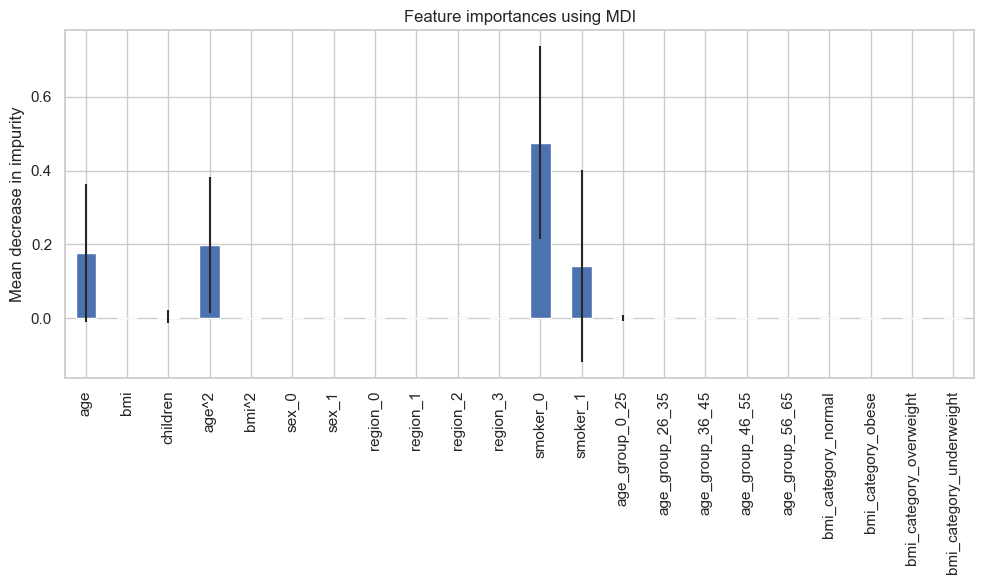

In [47]:
import pandas as pd
forest_importances = pd.Series(best_random_model.feature_importances_, index=list(X))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<h2>Training Random Forest on the best parameters</h2>

In [48]:
best_random_model = RandomForestRegressor(**study.best_params, random_state=42)

best_random_model.fit(X_train, y_train)

test_pred = best_random_model.predict(X_test)
test_mse = mean_squared_error(np.expm1(y_test), np.expm1(test_pred))
print("Test MSE:", test_mse)

Test MSE: 48229527.22382931


<h2>Linear Neural Network</h2>

In [49]:
!pip install torch


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import LeaveOneOut, KFold

<h4>Building and tuning the model</h4>
In order to achieve more dynamic results, we conduct training not only on hyperparameters but also another layer of training with number of layers and type of layers to automate architecture construction.

In [51]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

scaler = StandardScaler()
X_trainval = scaler.fit_transform(X_trainval)
X_test = scaler.transform(X_test)

X_trainval = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval = torch.tensor(y_trainval, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

INPUT_SIZE = X_trainval.shape[1]

class RegressionNet(nn.Module):
    def __init__(self, input_dim, hidden_size, n_layers, dropout_rate):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(n_layers):
            layers.extend([
                nn.Linear(in_dim, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            in_dim = hidden_size

        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def objective(trial):
    
    train_losses = []
    val_losses = []

    n_layers = trial.suggest_int("n_layers", 1, 6)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    N_EPOCHS = 40
    BATCH_SIZE = 64
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_mse = []

    for train_idx, val_idx in kf.split(X_trainval):
        X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
        y_tr, y_val = y_trainval[train_idx], y_trainval[val_idx]

        train_loader = DataLoader(
            TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False
        )

        model = RegressionNet(
            INPUT_SIZE, hidden_size, n_layers, dropout_rate
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, weight_decay=weight_decay
        )
        criterion = nn.MSELoss()

        epoch_train_losses = []
        epoch_val_losses = []

        for _ in range(N_EPOCHS):
            model.train()
            running_loss = 0.0

            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device).unsqueeze(1)

                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)
                
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        preds_all, targets_all = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                preds_all.append(model(xb.to(device)).cpu())
                targets_all.append(yb.unsqueeze(1))

        mse = mean_squared_error(
            torch.cat(targets_all).numpy(),
            torch.cat(preds_all).numpy()
        )
        fold_mse.append(mse)

    return np.mean(fold_mse)


In [52]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-12-25 11:47:39,827] A new study created in memory with name: no-name-532e2978-fd5c-42eb-b636-f1ab430b20ca
[I 2025-12-25 11:48:44,898] Trial 0 finished with value: 312918070.4 and parameters: {'n_layers': 5, 'hidden_size': 256, 'dropout_rate': 0.2670213333434106, 'lr': 0.0008095882778751222, 'weight_decay': 1.873101848382183e-06}. Best is trial 0 with value: 312918070.4.
[I 2025-12-25 11:49:41,426] Trial 1 finished with value: 309155737.6 and parameters: {'n_layers': 5, 'hidden_size': 256, 'dropout_rate': 0.14085989160329726, 'lr': 0.0009801037443869195, 'weight_decay': 2.9721125853045645e-05}. Best is trial 1 with value: 309155737.6.
[I 2025-12-25 11:49:55,131] Trial 2 finished with value: 316550086.4 and parameters: {'n_layers': 1, 'hidden_size': 256, 'dropout_rate': 0.17210345172641128, 'lr': 0.0005636963781259864, 'weight_decay': 1.6514264532142565e-06}. Best is trial 1 with value: 309155737.6.
[I 2025-12-25 11:50:10,084] Trial 3 finished with value: 320031769.6 and paramete

In [53]:
print("Best params:", study.best_params)

best = study.best_params

final_model = RegressionNet(
    INPUT_SIZE,
    best["hidden_size"],
    best["n_layers"],
    best["dropout_rate"]
).to(device)

optimizer = torch.optim.Adam(
    final_model.parameters(),
    lr=best["lr"],
    weight_decay=best["weight_decay"]
)

criterion = nn.MSELoss()
train_loader = DataLoader(
    TensorDataset(X_trainval, y_trainval), batch_size=64, shuffle=True
)

for epoch in range(40):
    final_model.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()


Best params: {'n_layers': 1, 'hidden_size': 256, 'dropout_rate': 0.1221559225062747, 'lr': 0.007842434845000842, 'weight_decay': 1.7569626700592314e-05}


Tuning performance

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

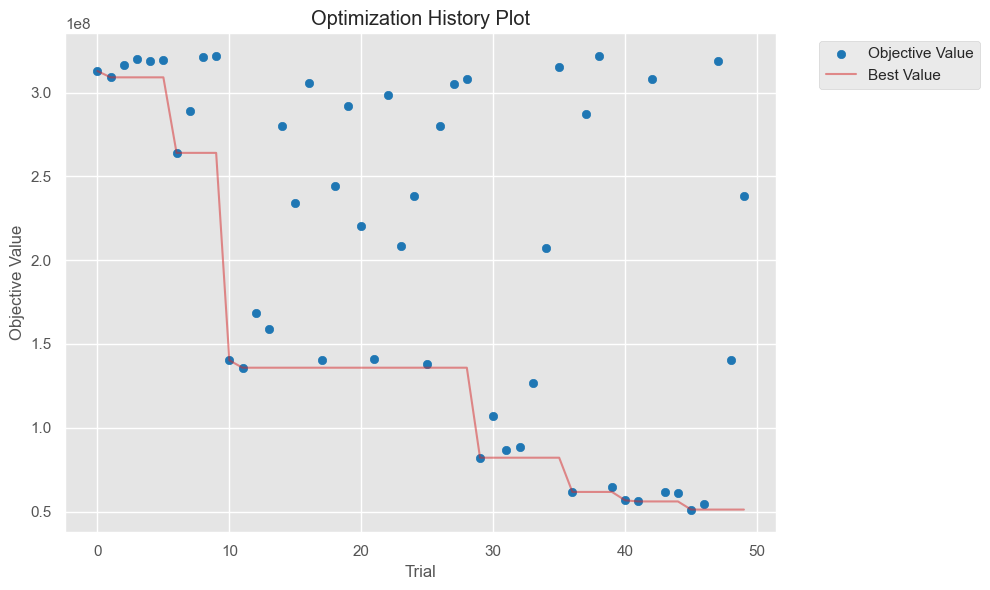

In [54]:
#optuna.visualization.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_optimization_history(study)

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

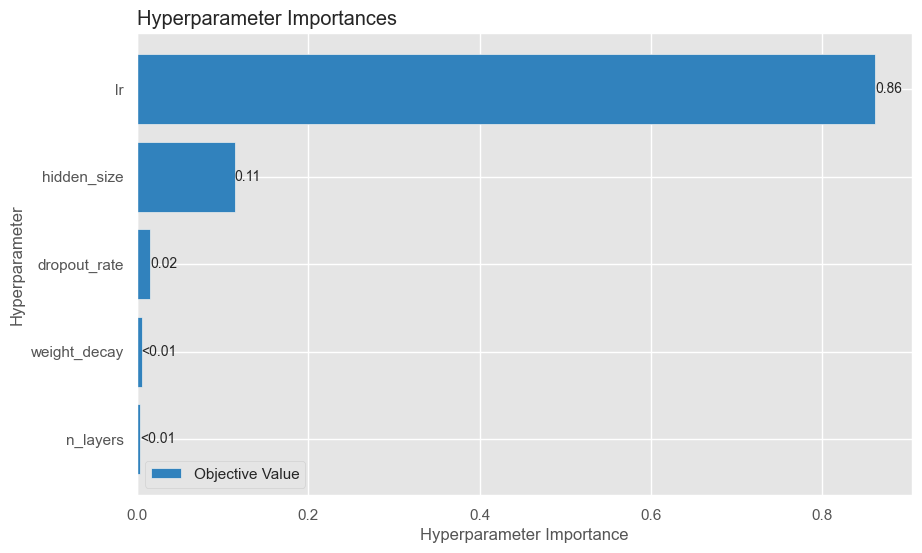

In [55]:
#optuna.visualization.plot_param_importances(study)
optuna.visualization.matplotlib.plot_param_importances(study)

Final results of training
The model did not outperform the classical ML models. It is also very expensive in computation and time consuming.

In [56]:
#y_train = torch.tensor(y_train.values, dtype=torch.float32)

final_model.eval()
with torch.no_grad():
    train_preds = final_model(X_trainval.to(device)).cpu().numpy()

train_mse = mean_squared_error(y_trainval.numpy(), train_preds)
train_mae = mean_absolute_error(y_trainval.numpy(), train_preds)
train_mape = mean_absolute_percentage_error(y_trainval.numpy(), train_preds)
train_r2 = r2_score(y_trainval.numpy(), train_preds)
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MAPE: {train_mape:.4f}")
print(f"Train R2: {train_r2:.4f}")

Train MSE: 37617152.0000
Train MAE: 4076.5586
Train MAPE: 0.3571
Train R2: 0.7415


In [57]:
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test.to(device)).cpu().numpy()

test_mse = mean_squared_error(y_test.numpy(), test_preds)
test_mae = mean_absolute_error(y_test.numpy(), test_preds)
test_mape = mean_absolute_percentage_error(y_test.numpy(), test_preds)
test_r2 = r2_score(y_test.numpy(), test_preds)
print(f"TEST MSE: {test_mse:.4f}")
print(f"TEST MAE: {test_mae:.4f}")
print(f"TEST MAPE: {test_mape:.4f}")
print(f"TEST R2: {test_r2:.4f}")


TEST MSE: 31898506.0000
TEST MAE: 3908.3125
TEST MAPE: 0.3701
TEST R2: 0.7905


<h4>Network Structure</h4>

In [59]:
from torchinfo import summary

summary(final_model, input_size=(1, INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
RegressionNet                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 256]                  5,888
│    └─BatchNorm1d: 2-2                  [1, 256]                  512
│    └─ReLU: 2-3                         [1, 256]                  --
│    └─Dropout: 2-4                      [1, 256]                  --
│    └─Linear: 2-5                       [1, 1]                    257
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [60]:
final_model

RegressionNet(
  (network): Sequential(
    (0): Linear(in_features=22, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1221559225062747, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

<h4>Visualizing predictions of the model</h4>

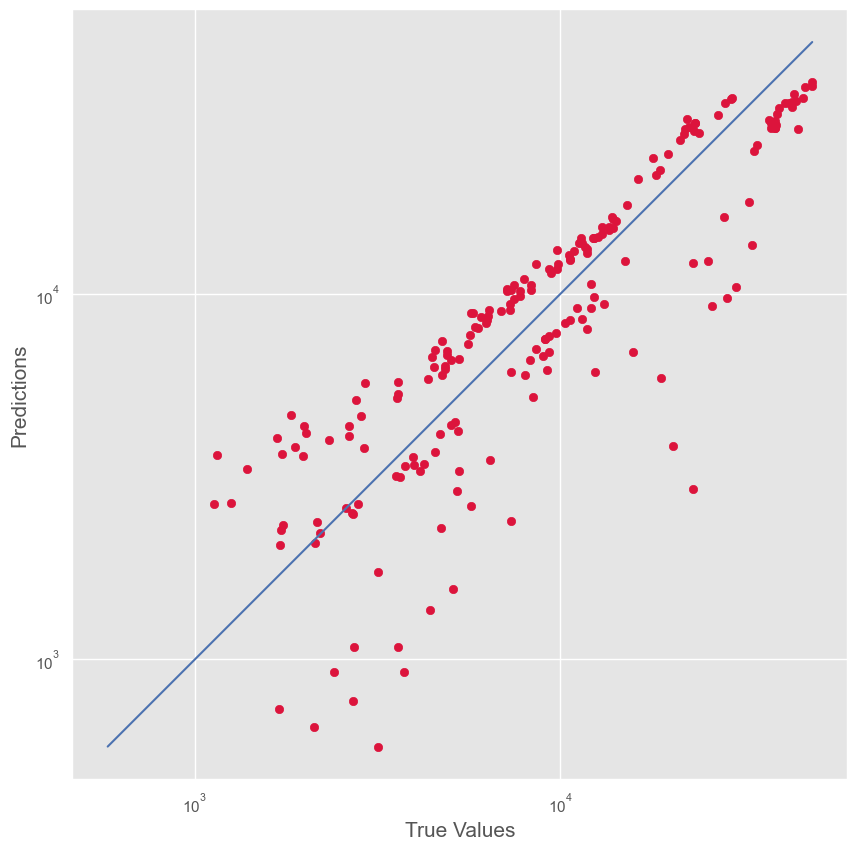

In [61]:
y_pred = test_preds.squeeze()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

<h2>XGBoost Regressor</h2>

In [62]:
import xgboost

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                   test_size=0.30, 
                                   shuffle=True,
                                   random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                   test_size=0.50, 
                                   shuffle=True,
                                   random_state=42)

<h3>Basic XGBoost Model</h3>

In [64]:
xgb_model = xgboost.XGBRegressor(n_estimators=10, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [65]:
test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test MAPE:", test_mape)
print("Test R2:", test_r2)

Test MSE: 0.22458192307345679
Test MAE: 0.3509803732678428
Test MAPE: 0.0392084661085726
Test R2: 0.7313933001925401


In [66]:
def xgb_objective(trial):
    params ={
        'n_estimators': trial.suggest_int("n_estimators", 100, 500, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'eta': trial.suggest_float("eta", 0.1, 0.99),
        'subsample':  trial.suggest_float('subsample', 0.2, 0.99),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.1, 0.99),
        'gamma': trial.suggest_float('gamma', 0.1, 0.99),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.99),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.99),
        #'booster': trial.suggest_categorical('booster', ['dart', 'linear'])

    }
    clf = xgboost.XGBRegressor(**params, random_state=42, n_jobs=8)
    clf.fit(X_train, y_train, verbose=True)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

    return -scores.mean()

In [67]:
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=97)

[I 2025-12-25 12:20:13,794] A new study created in memory with name: no-name-438ccfa1-81c4-4df6-a23b-ce0d1524abbd
[I 2025-12-25 12:20:14,288] Trial 0 finished with value: 0.3372483383947766 and parameters: {'n_estimators': 249, 'max_depth': 10, 'eta': 0.9882223710213437, 'subsample': 0.9229576914013276, 'colsample_bytree': 0.12915377756179902, 'gamma': 0.5614364577857044, 'reg_alpha': 0.7444230102165245, 'reg_lambda': 0.5791930204493705}. Best is trial 0 with value: 0.3372483383947766.
[I 2025-12-25 12:20:15,105] Trial 1 finished with value: 0.2791956845449187 and parameters: {'n_estimators': 485, 'max_depth': 6, 'eta': 0.8418572724805136, 'subsample': 0.5156399392146505, 'colsample_bytree': 0.8133078211204604, 'gamma': 0.4723001476205192, 'reg_alpha': 0.9474092299707818, 'reg_lambda': 0.6043164162547189}. Best is trial 1 with value: 0.2791956845449187.
[I 2025-12-25 12:20:15,654] Trial 2 finished with value: 0.22253352983750707 and parameters: {'n_estimators': 331, 'max_depth': 6, 'et

<h3>Tuning Performance</h3>
Ignore the error message. The plot is executiong properly

In [68]:
optuna.visualization.plot_optimization_history(xgb_study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
              'y': [0.3372483383947766, 0.2791956845449187, 0.22253352983750707,
                    0.22322253630795816, 0.22376859804842503, 0.29142598762165284,
                    0.2454038013503065, 0.25170092803876887, 0.2308033295113197,
                    0.23265061422625877, 0.23679889346016453, 0.22202191899950527,
                    0.22253327480889445, 0.21742436838345927, 0.21517413626669696,
                    0.21807588149235313, 0.22267140088522122, 0.21636052245342557,
                    0.272631113019829, 0.21332619783388945, 0.20895076153978417,
                    0.21747061040322122, 0.2129752159088012, 0.21314624968833576,
                    0.21231673975233037, 0.215832376042361, 0.20882237081332136,
                    0.2901934176906364, 0.2083033347580349, 0.2618561890442601,
                    0.24478919940537835, 0.20963881957609548, 0.22583833270303008,
                    0.20469587627923214, 0.22585990477097573, 0.21325807471149,
                    0.20919986959910827, 0.23636795311011194, 0.22642139866241018,
                    0.21161490457550314, 0.2203638974213149, 0.20964603279072525,
                    0.217142576418036, 0.21578054720743553, 0.21243373957808181,
                    0.24890661576032008, 0.23484568015104745, 0.21958030185243768,
                    0.20958314182762305, 0.2153560330068251, 0.20807093433191848,
                    0.20539318160021627, 0.206160473600973, 0.2091058332740429,
                    0.20663955093690595, 0.2065501163708406, 0.20421382193280296,
                    0.20633826411624162, 0.20733427269771765, 0.20792564798053745,
                    0.20722699651438709, 0.20692012920039468, 0.2070046485650791,
                    0.20953008458575112, 0.2113920845406864, 0.20653997684089537,
                    0.21027231301625626, 0.2052790310543903, 0.21192865934568736,
                    0.21401988753675472, 0.20901491951379542, 0.20938170891502966,
                    0.2046747372059543, 0.20249704906294363, 0.2005824591114657,
                    0.21212331457119152, 0.20225270067050358, 0.2044350731575273,
                    0.2132540800280862, 0.20647464331154164, 0.20426421004111392,
                    0.2056927706075013, 0.2073637581482745, 0.20979054021433896,
                    0.23271399588503688, 0.20339917743891417, 0.21186292709929128,
                    0.20336852148152076, 0.20419038175058696, 0.2033354205500756,
                    0.209963036072691, 0.20003500764752574, 0.2009181737577363,
                    0.20172366646688814, 0.20255810054567464, 0.2025105031196154,
                    0.2103249319762736]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
              'y': [0.3372483383947766, 0.2791956845449187, 0.22253352983750707,
                    0.22253352983750707, 0.2

In [69]:
optuna.visualization.plot_param_importances(xgb_study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [n_estimators (IntDistribution):
                                0.0031563611843668216<extra></extra>, reg_alpha
                                (FloatDistribution):
                                0.0067802554385609955<extra></extra>, reg_lambda
                                (FloatDistribution):
                                0.015302384304950864<extra></extra>, max_depth
                                (IntDistribution):
                                0.020946906949034703<extra></extra>, gamma
                                (FloatDistribution):
                                0.041217093141711375<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.17274383989649753<extra></extra>, subsample
                                (FloatDistribution):
                                0.23397251085072027<extra></extra>, eta
                                (FloatDistribution):
                                0.5058806482341577<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, 0.02, 0.02, 0.04, 0.17, 0.23, 0.51],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0031563611843668216, 0.0067802554385609955,
                    0.015302384304950864, 0.020946906949034703,
                    0.041217093141711375, 0.17274383989649753, 0.23397251085072027,
                    0.5058806482341577],
              'y': [n_estimators, reg_alpha, reg_lambda, max_depth, gamma,
                    colsample_bytree, subsample, eta]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

<h4>Choosing best model</h4>
It may differ slightly based on tuning loss function

In [70]:
trial = xgb_study.trials[93] #best set of parameters

In [71]:
best_xgb_model = xgboost.XGBRegressor(**trial.params, random_state=42)

In [72]:
import joblib

joblib.dump(best_xgb_model, "xgb1.joblib.dat")


['xgb1.joblib.dat']

<h4>Printing final results</h3>

In [73]:
from sklearn.metrics import root_mean_squared_error

loaded_model = joblib.load("xgb1.joblib.dat")
best_xgb_model.fit(X_train, y_train)

xgb_pred = best_xgb_model.predict(X_train)
xgb_mae = mean_absolute_error(np.expm1(y_train), np.expm1(xgb_pred))
xgb_mape = mean_absolute_percentage_error(np.expm1(y_train), np.expm1(xgb_pred))
xgb_r2 = r2_score(np.expm1(y_train), np.expm1(xgb_pred))

print("XGB TRAINING MAE: ", xgb_mae)
print("XGB TRAINING MAPE: ", xgb_mape)
print("XGB TRAINING R2: ", xgb_r2)

val_pred = best_xgb_model.predict(X_val)

val_mae = mean_absolute_error(np.expm1(y_val), np.expm1(val_pred))
val_mape = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(val_pred))
val_r2 = r2_score(np.expm1(y_val), np.expm1(val_pred))

print("XGB VAL MAE: ", val_mae)
print("XGB VAL MAPE: ", val_mape)
print("XGB VAL R2: ", val_r2)


XGB TRAINING MAE:  1994.644236894198
XGB TRAINING MAPE:  0.15418407270685863
XGB TRAINING R2:  0.8706278557472112
XGB VAL MAE:  2012.0612407681128
XGB VAL MAPE:  0.17530133238169016
XGB VAL R2:  0.8692633904124624


In [74]:
test_pred = best_xgb_model.predict(X_test)

def XGBtest(best_model):
    test_pred = best_model.predict(X_test)

    test_mse = mean_squared_error(np.expm1(y_test), np.expm1(test_pred))
    test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(test_pred))
    test_r2 = r2_score(np.expm1(y_test), np.expm1(test_pred))
    test_mape = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(test_pred))

    print("Test MSE:", test_mse)
    print("Test MAE:", test_mae)
    print("Test R2:", test_r2)
    print("Test MAPE:", test_mape)

    return [test_mse, test_mae, test_mape, test_r2, test_pred]

XGBtest(best_model=best_xgb_model)

Test MSE: 19876935.15487652
Test MAE: 2036.878876353584
Test R2: 0.8689281699847684
Test MAPE: 0.15477822352830548


[19876935.15487652,
 2036.878876353584,
 0.15477822352830548,
 0.8689281699847684,
 array([ 8.081522 ,  9.5865   ,  8.571335 ,  9.423772 ,  8.672291 ,
        10.475984 ,  8.283543 , 10.574774 , 10.403328 ,  9.100998 ,
         9.276968 ,  8.863974 ,  8.271079 ,  9.250454 ,  8.841963 ,
         9.431812 ,  8.3429985, 10.614763 ,  8.582138 ,  9.210289 ,
         9.421318 , 10.779067 ,  8.41576  ,  9.108105 ,  9.211547 ,
         8.638653 ,  9.3586035,  9.60947  ,  8.782505 ,  9.511063 ,
         9.316414 ,  9.618886 ,  9.844803 , 10.58553  , 10.287006 ,
         9.490909 , 10.621204 ,  9.420539 , 10.403626 ,  9.322684 ,
         8.767819 ,  9.353433 ,  8.703042 ,  9.44573  ,  8.6463785,
        10.108553 ,  9.39322  ,  8.215345 ,  7.351446 ,  8.470665 ,
         8.437973 ,  9.343977 ,  7.6046624,  8.932349 ,  9.423104 ,
        10.55588  ,  8.786063 ,  8.842524 ,  8.966241 ,  7.399701 ,
         8.633747 ,  9.4293   ,  9.149795 ,  8.62516  ,  7.5996933,
         9.425562 ,  7.7796097,  

The model explains 87% of variance, the average deviation from real value is 17%, which results in approximately $2011 of charge size deviation. Possible solutions to boost performance will be a tradeoff of removed outliers wihich in our case will remove information about the special cases of people, effectively masking their inclusion but boosting MAE/MAPE even further. The second option is to simply add new variable, for example education to better explain random elements. 

Test MSE: 19876935.15487652
Test MAE: 2036.878876353584
Test R2: 0.8689281699847684
Test MAPE: 0.15477822352830548


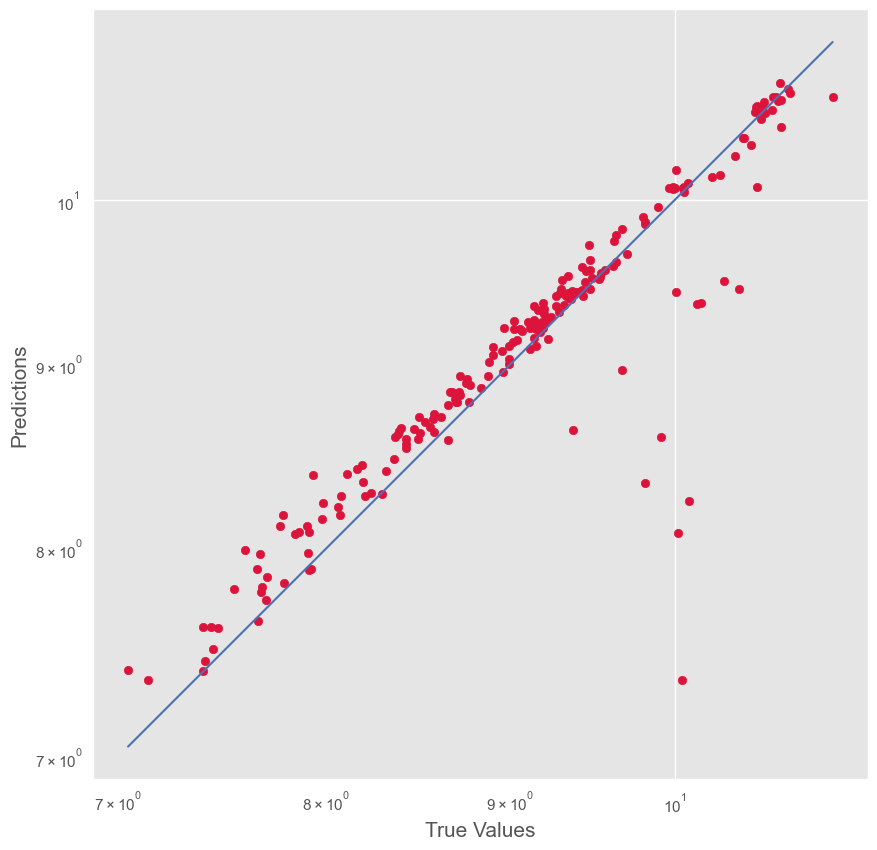

In [75]:
y_pred = XGBtest(best_xgb_model)

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred[4], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred[4]), max(y_test))
p2 = min(min(y_pred[4]), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

<h3>The model has interesting impact on the final results</h3> 
The SHAP plot will explain how each of variables affects final result.

In [76]:
!pip install shap scipy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

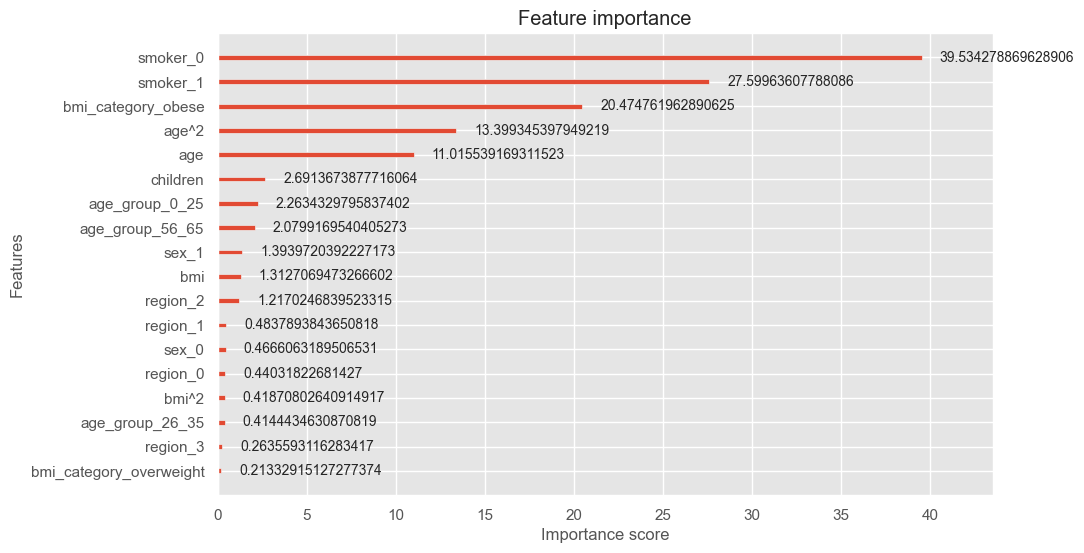

In [77]:
from xgboost import plot_importance
plot_importance(best_xgb_model, importance_type='gain')

<h3>Experimental part - training model on smaller number of predictors</h3>
Recursive feature elimination with cross-validation to select best set of features

In [ ]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor

model = best_xgb_model
selector = RFECV(model, step=1, cv=5, scoring='neg_root_mean_squared_error')
selector.fit(X_train, y_train)
X_selected = X_train.loc[:, selector.support_]

<h3>Conducting tuning for XGBoost model</h3>

In [ ]:
def xgb_objective_exp(trial):
    params ={
        'n_estimators': trial.suggest_int("n_estimators", 100, 500, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'eta': trial.suggest_float("eta", 0.1, 0.99),
        'subsample':  trial.suggest_float('subsample', 0.2, 0.99),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.1, 0.99),
        'gamma': trial.suggest_float('gamma', 0.1, 0.99),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.99),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.99),
        #'booster': trial.suggest_categorical('booster', ['dart', 'linear'])

    }
    clf = xgboost.XGBRegressor(**params, random_state=42, n_jobs=8)
    clf.fit(X_selected, y_train, verbose=True)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_selected, y_train, cv=cv, scoring='neg_mean_absolute_error')

    return -scores.mean()

In [ ]:
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective_exp, n_trials=97)

[I 2025-12-20 13:44:51,486] A new study created in memory with name: no-name-d6541169-0b38-459b-ab0b-0c50c55b6ac8
[I 2025-12-20 13:44:52,529] Trial 0 finished with value: 0.2500697479505162 and parameters: {'n_estimators': 458, 'max_depth': 7, 'eta': 0.8022715897022007, 'subsample': 0.6414094431191966, 'colsample_bytree': 0.43613919678634516, 'gamma': 0.4859670557149195, 'reg_alpha': 0.6945124290136705, 'reg_lambda': 0.15148211609817003}. Best is trial 0 with value: 0.2500697479505162.
[I 2025-12-20 13:44:53,483] Trial 1 finished with value: 0.2168176749042948 and parameters: {'n_estimators': 283, 'max_depth': 10, 'eta': 0.5907259925457099, 'subsample': 0.9564886990274695, 'colsample_bytree': 0.5523662092281619, 'gamma': 0.2880451148181278, 'reg_alpha': 0.3256964276594318, 'reg_lambda': 0.7969904064046588}. Best is trial 1 with value: 0.2168176749042948.
[I 2025-12-20 13:44:54,226] Trial 2 finished with value: 0.28214234950849554 and parameters: {'n_estimators': 202, 'max_depth': 10, '

<h3>Results of Tuning</h3>

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

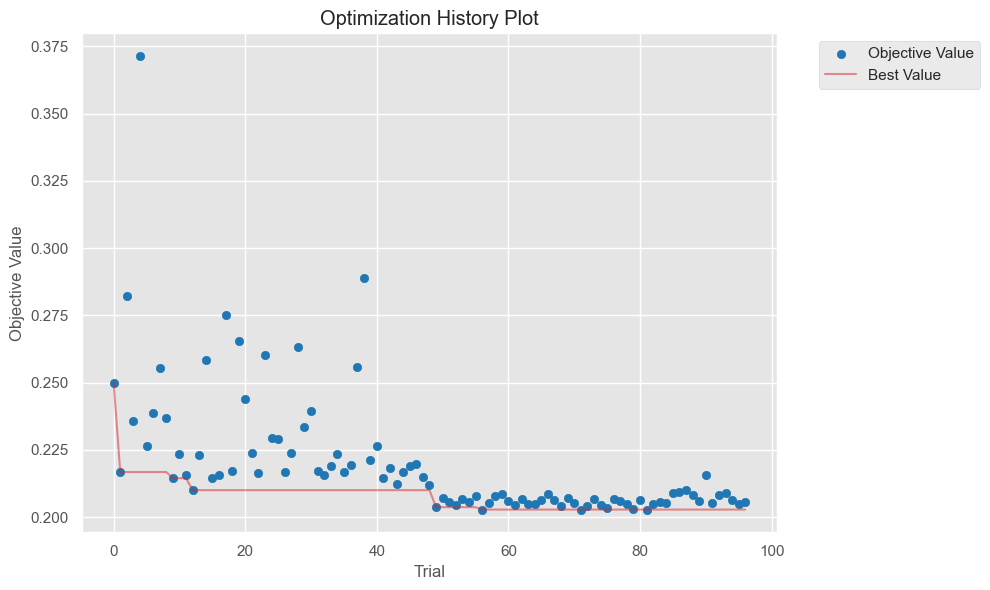

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(xgb_study)

In [ ]:
exp_xgb_model = xgboost.XGBRegressor(**trial.params, random_state=42)

<h3>The model does not improve upon removal of irrelevent features thus it won't be considered for final results</h3>

<h2>Models exporting</h2>
The models are exported: Random Forest and XGBoost to pickle and Neural Network to pt.

In [86]:
xgb_model

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [87]:
tree_regressor

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

In [ ]:
import joblib

#export of random forest
with open("./app/models/rf_regressor.pkl", "wb") as f:
    joblib.dump(best_random_model, f)

#export og nn
MODEL_PATH = "./app/models/regression_model.pt"
torch.save({
    "model_state_dict": final_model.state_dict(),
    "input_size": INPUT_SIZE
}, MODEL_PATH)

best_xgb_model_booster = best_xgb_model.get_booster()

#export of xgboost regressor
best_xgb_model_booster.save_model("./app/models/xgb_model_small.json")
with open("./app/models/xgb_regressor.pkl", "wb") as f:
    joblib.dump(xgb_model, f)

<h2>Bibliography</h2>

Random Forest
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://towardsdatascience.com/understanding-random-forest-using-python-scikit-learn/
- https://kirenz.github.io/regression/docs/randomforest.html

Neural Network
- https://www.kaggle.com/code/zahrazolghadr/neural-network-model-for-regression
- https://www.kaggle.com/code/zahrazolghadr/neural-network-model-for-regression
- https://www.d2l.ai/chapter_linear-regression/index.html

XGBoost
- https://www.geeksforgeeks.org/machine-learning/xgboost/
- https://xgboost.readthedocs.io/en/stable/

Data source:
- https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset

Insurance theory
- https://onlinelibrary.wiley.com/doi/abs/10.1002/asmb.2543
- https://www.mdpi.com/2227-9091/9/2/42
- https://www.researchgate.net/profile/Kofi-Jones/publication/371794479_The_Implementation_of_Machine_Learning_In_The_Insurance_Industry_With_Big_Data_Analytics/links/649c6d9d8de7ed28ba6180cc/The-Implementation-of-Machine-Learning-In-The-Insurance-Industry-With-Big-Data-Analytics.pdf
- https://link.springer.com/article/10.1007/s13385-019-00215-z